In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [2]:
dataset = pd.read_csv('train_2v.csv')

Find the columns and percentage of NaNs in the training and data

In [3]:
null_check=((dataset.isnull().sum()/len(dataset))*100).sort_values(ascending=False)
null_check

smoking_status       30.626728
bmi                   3.368664
stroke                0.000000
avg_glucose_level     0.000000
Residence_type        0.000000
work_type             0.000000
ever_married          0.000000
heart_disease         0.000000
hypertension          0.000000
age                   0.000000
gender                0.000000
id                    0.000000
dtype: float64

BMI and smoking status have missing data, mean value replacement for bmi and dropping the NaN rows for smoking status since its effect on health stroke is well known. Also drop the IDs and check for the missing data again.

In [4]:
dataset['bmi']=dataset.bmi.fillna(dataset.bmi.mean())
dataset.dropna(inplace=True)
dataset=dataset.drop('id', axis=1)
null_check=((dataset.isnull().sum()/len(dataset))*100).sort_values(ascending=False)
null_check

stroke               0.0
smoking_status       0.0
bmi                  0.0
avg_glucose_level    0.0
Residence_type       0.0
work_type            0.0
ever_married         0.0
heart_disease        0.0
hypertension         0.0
age                  0.0
gender               0.0
dtype: float64

No missing data left. Check the correlation on the matrix and scattering plots

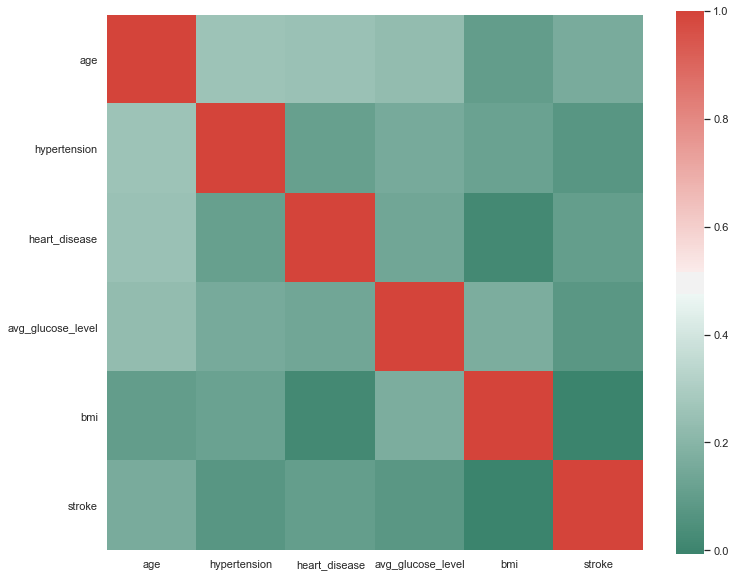

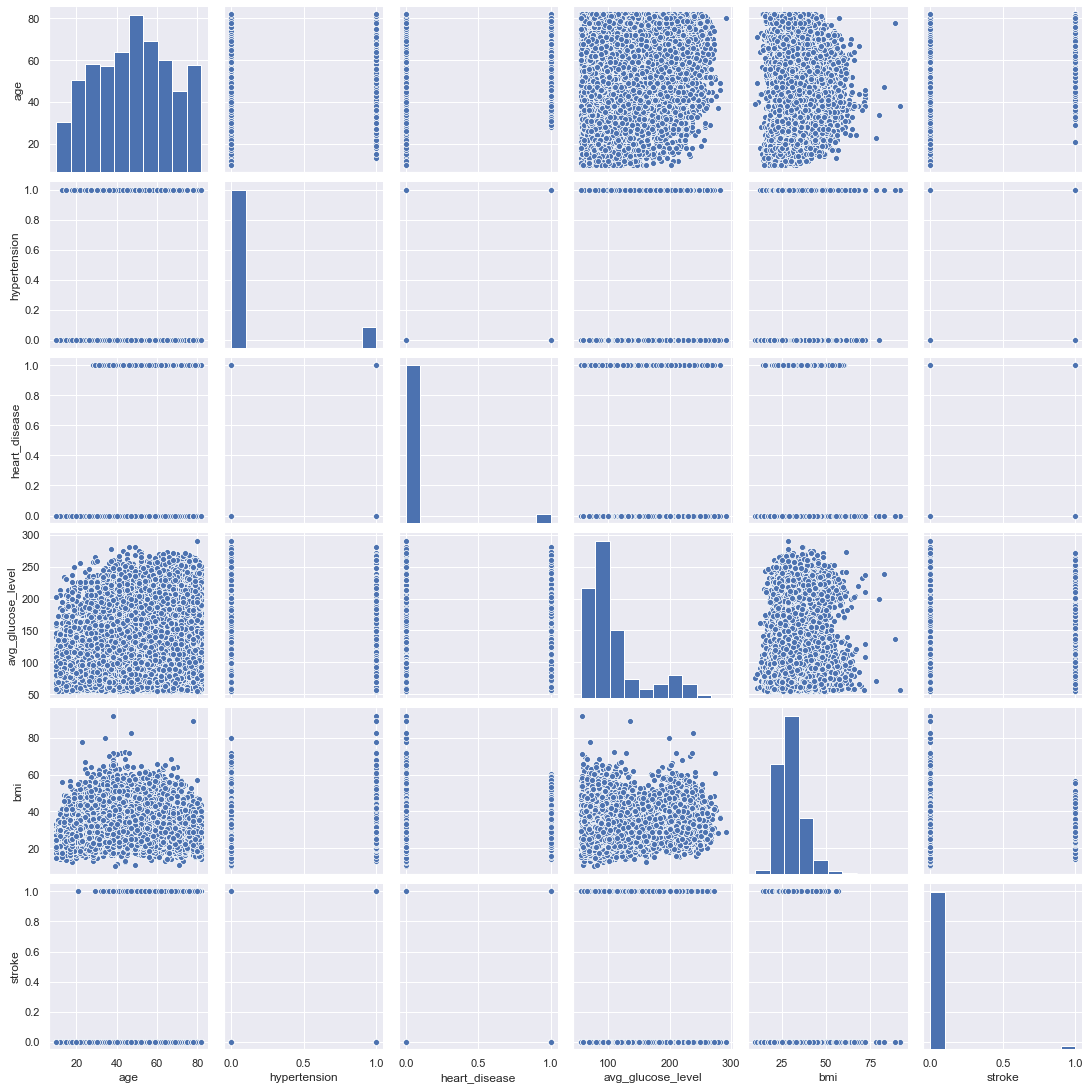

In [7]:
f,ax=plt.subplots(figsize=(12,10))
corr=dataset.corr()
#sns.heatmap(dataset.corr(),mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(520,14,as_cmap=True),square=True, ax=ax)
sns.heatmap(dataset.corr())
#cmap=sns.diverging_palette(520,14,as_cmap=True),square=True, ax=ax)
sns.set()
sns.pairplot(dataset)
plt.show()


Only 1 heart stroke at an age younger than 25

No heart attack for average glucose level higher than 280

No heart attack for BMI larger than 55

Let's try a clustering on those variables to see high risk groups. I'm doing an elbow analysis first then clustering using the optimum number of clusters

So the the data is mostly clustered along avg glucose level; however, let's plot the 3D scattering with stroke labels and see if the risk groups are determined by glucose level:

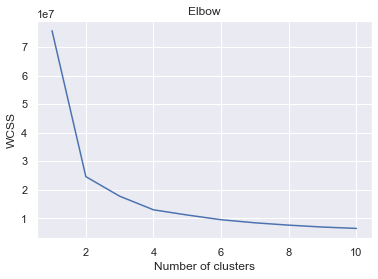

In [8]:
datacl=dataset[['age','avg_glucose_level','bmi']]
X_cl=datacl.iloc[:,:].values

from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=400, n_init=10, random_state=0)
    kmeans.fit(X_cl)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=400, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_cl)
sum(y_kmeans)/len(y_kmeans)

0.1556396970904743

<IPython.core.display.Javascript object>


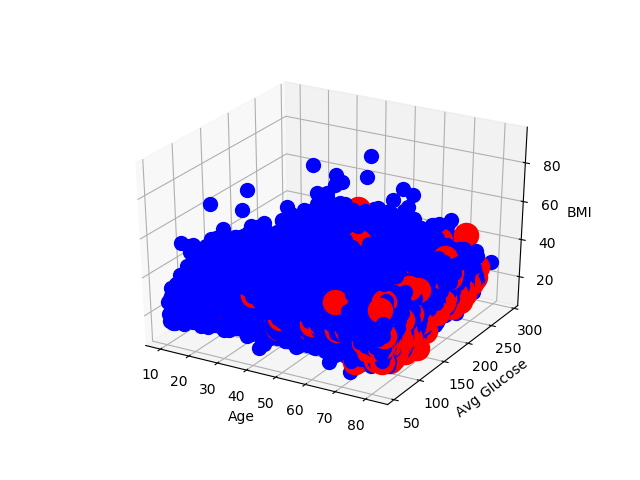

<function matplotlib.pyplot.show(*args, **kw)>

In [10]:
ycl=dataset.loc[:,'stroke'].values

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(1,ycl.size):
    if ycl[i] == 0:
        ax.scatter(X_cl[i,0], X_cl[i,1], X_cl[i,2], s=100, c='b', marker='o')
    else:
        ax.scatter(X_cl[i,0], X_cl[i,1], X_cl[i,2], s=300, c='r', marker='o')
        
ax.set_xlabel('Age')
ax.set_ylabel('Avg Glucose')
ax.set_zlabel('BMI')        
plt.show        


So the interactive 3D plot shows that the age is more dominant effect to determine the risk group even though K-NN clustering was done with respect to glucose level.

Now I'm gonna hot encode the categorical variables and check the balance of heart stroke distribution that is the balance of the data. However, I'm gonna assign stroke column to my independent variable and then drop that column before encoding and the reason is get_dummies gives different order of columns depending on the number of columns in a given data set. I want to have same order of columns with this training set and the other test set(without heat stroke data) I'll be taking in. I wonder how Label Encoder of Sklearn would do this, can be checked in the future.

In [13]:
y = dataset.loc[:, dataset.columns == 'stroke'].values
dataset['stroke'].value_counts()
dataset=dataset.drop('stroke', axis=1)
dataset = pd.get_dummies(dataset)
dataset.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Rural', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

Almost 2% is stroke, which is a good sign for human health but it is bad for the balance of our data. Let's augment the data by Random Over Smapling and separate the dependent and independent variables

In [14]:
ros = RandomOverSampler(random_state=0)
X = dataset.loc[:,:].values
X[0,:]

array([58.  ,  1.  ,  0.  , 87.96, 39.2 ,  0.  ,  1.  ,  0.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
        1.  ,  0.  ])

In [15]:
X.shape

(30108, 20)

Feature Scaling on only non-encoded columns which are 0,3 and 4. And then the data is ready to split.

In [29]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X[:,[0,3,4]] = sc_X.fit_transform(X[:,[0,3,4]])
X_sampled,y_sampled = ros.fit_resample(X,y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_sampled, y_sampled, np.arange(len(X_sampled)), test_size = 0.2, random_state = 0)


Lets use Random Forest Classification which is considered as powerful and accurate. Check the predictions through Confusion Matrix.

In [18]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=90,criterion='entropy',random_state=0)
classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

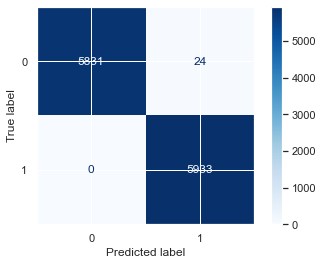

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues)

In [45]:
#dataset = dataset.reset_index(drop=True)
#dataset_test = dataset.iloc[indices_test,:]
#dataset_test.head()
dataset_test = pd.DataFrame(data=X_sampled[indices_test], columns = dataset.columns)
dataset_test['Prediction'] = y_pred
dataset_test['True_value'] = y_test
dataset_test.to_csv('splitted_testset.csv')

In [21]:
testdata = pd.read_csv('test_2v.csv')
testdata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,11111,Male,29.0,0,0,No,Govt_job,Urban,130.00,26.5,smokes
1,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
2,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
3,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
4,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN


So the first row of entry is mine, and I'm following the same data sanitation I've done for the training set. I am not doing any concating as the categorical variables are exactly same but let me be sure about missing points very quick and then keep cleaning up, hot encoding and feature scaling.

In [22]:
null_check=((testdata.isnull().sum()/len(testdata))*100).sort_values(ascending=False)
testdata['bmi']=testdata.bmi.fillna(testdata.bmi.mean())
testdata.dropna(inplace=True)
testdata=testdata.drop('id', axis=1)
testdata = pd.get_dummies(testdata)

In [23]:
testdata.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,29.0,0,0,130.00,26.5,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1
1,80.0,0,0,83.84,21.1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0
2,74.0,0,1,179.50,26.0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0
5,63.0,0,0,83.57,27.6,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
6,66.0,1,0,219.98,32.2,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0


So the test set looks ready to predict on and I am still in the first entry. I am a little nervous about it but lets scale the features and see the prediction.

In [24]:
X_test2 = testdata.loc[:,:].values
X_test2[:,[0,3,4]] = sc_X.fit_transform(X_test2[:,[0,3,4]])
y_pred2 = classifier.predict(X_test2)
y_pred2.sum()

54

In [25]:
y_pred2[0]

0

Yay! I am sorry for the other 54 people in the new test set but apparently I'm not going to have heart attack.